Copyright (c) 2024-2025, NVIDIA CORPORATION & AFFILIATES

SPDX-License-Identifier: BSD-3-Clause

# FP8 computations with nvmath-python

In this tutorial we will introduce the narrow-precision FP8 formats and demonstrate how to use nvmath-python to perform computations in FP8 and MXFP8 formats.

## Table of Contents
1. Classic floating-point formats
2. Narrow-precision floating-point formats (FP8)
3. FP8 operations with nvmath-python
4. MXFP8 (microscaling FP8) operations with nvmath-python

## Classic floating-point formats
[Floating point numbers](https://en.wikipedia.org/wiki/Floating-point_arithmetic) consist of a *significand* (also known as *mantissa*) multiplied by an integral power of 2 (*exponent*). Except for certain special cases (such as infinity, NaN, or [subnormal numbers](https://en.wikipedia.org/wiki/Subnormal_number)), the value of the number is:
$$
\pm\;\text{significand} \cdot 2 ^ {\;\text{exponent}}
$$

In a typical floating point number, a fixed number of bits store the exponent and the significand. For example, in the [IEEE 754 32-bit float](https://en.wikipedia.org/wiki/Single-precision_floating-point_format) (also known as single-precision float), 23 bits store the significand, 8 bits store the exponent, and one last bit indicates the sign of the number. 

The two most important characteristics of a floating point number are:
- *Precision*, which is the number of bits in the significand. Precision determines the number of representable values on a certain interval.
- *Dynamic range*, which is the range of representable values. The dynamic range is determined by the number of bits for the exponent.

### High-precision formats

In scientific computations, where precision is extremely important, single-precision formats are sometimes not enough. For this reason, some formats aim to increase precision and range by using more bits for both the significand and exponent. This includes the [double-precision 64-bit floats](https://en.wikipedia.org/wiki/Double-precision_floating-point_format), which use 11 bits for the exponent and 52 bits for the significand, but also even wider formats, such as [quadruple-precision 128-bit floats](https://en.wikipedia.org/wiki/Quadruple-precision_floating-point_format) or [octuple-precision 256-bit floats](https://en.wikipedia.org/wiki/Octuple-precision_floating-point_format).

### 16-bit formats

In certain use cases, most notably in the training of deep learning networks, the exact computations are not as important, and lower-precision formats can offer a better trade-off between performance and precision. Using 16-bit floating point numbers, which occupy half the memory of a classic float, can significantly speed up memory-bound computations, while maintaining an acceptable precision. The two most common 16-bit floating point types are:

- [Half-precision (FP16)](https://en.wikipedia.org/wiki/Half-precision_floating-point_format), with 5 bits for the exponent and 10 bits for the significand.
- [Bfloat16](https://en.wikipedia.org/wiki/Bfloat16_floating-point_format) (*brain* float), with 8 bits for the exponent and 7 bits for the significand. The dynamic range of `bfloat16` matches that of a single-precision float since both have 8 bits for the exponent. However, this comes at the cost of significantly reduced precision.

The 16-bit formats are particularly useful in mixed-precision tensor cores, where the critical parts of computation are done in FP32. This offers good precision while enabling high-throughput matrix multiplication, which is crucial for AI applications.
 
An interesting alternative to 16-bit data types is the [TF32](https://en.wikipedia.org/wiki/TensorFloat-32) format, which is an internal computation format available on NVIDIA Tensor Cores. It has 8 exponent bits (matching FP32) and 10 significand bits (matching FP16).

## Narrow-precision (FP8 and lower) formats

Even smaller floating point formats have recently gained popularity. While narrow-precision formats are not practical in many areas, they still perform well in Deep Learning applications, especially in the inference. In nvmath-python, we support 8-bit floating point types. However, even smaller types are used, such as 6-bit FP6 type or even 4-bit FP4.

The two most commonly used FP8 formats are `float8_e4m3fn` and `float8_e5m2`.

The `float8_e4m3fn` format has 4 bits for the exponent (`e4`) and 3 bits for the significand (`m3`). The `fn` suffix indicates that the number is finite, meaning there's no special value indicating infinity. With just 4 bits for the exponent, the dynamic range of `float8_e4m3fn` is very small - its maximum value is just 448.

The second format, `float8_e5m2`, has one more bit reserved for the exponent, allowing it to store values up to 57344. However, this comes at the cost of reduced precision due to having one fewer bit for the significand.

To illustrate the precision of these types, let's plot their representable values between 0 and 20 and between 0 and 2000. Note how `float8_e5m2` has half the density of `float8_e4m3fn` due to having one less bit for the significand, but has much wider dynamic range. Also notice that 9 is not representable in `float8_e5m2`, and 17 is not representable in `float8_e4m3fn`.

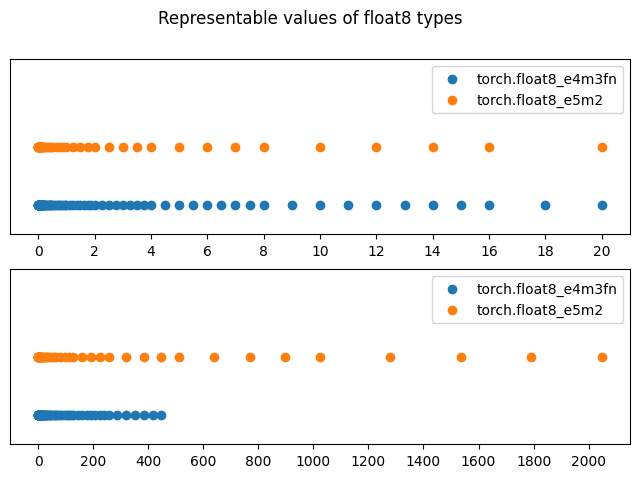

In [1]:
import torch
from matplotlib import pyplot as plt


fig, axs = plt.subplots(2, 1, figsize=(8, 5))
for ax, limit in zip(axs, (20, 2000), strict=True):
    x = torch.linspace(0, limit, 10**4)
    for i, dtype in enumerate((torch.float8_e4m3fn, torch.float8_e5m2)):
        representable_values = x.type(dtype).type(torch.float32).unique()  # Cast to float8 dtype and back
        ax.scatter(representable_values, torch.full_like(representable_values, i), label=repr(dtype))
    ax.set_ylim(-0.5, 2.5)
    ax.set_yticks([])
    ax.set_xticks(torch.linspace(0, limit, 11, dtype=torch.int32))
    ax.legend()
fig.suptitle("Representable values of float8 types");

### FP8 scaling

Due to the very limited dynamic range of FP8 types, the results of FP8 GEMM rarely fit into the dynamic range of FP8. To address this issue, we use *scaling factors* for each operand to ensure they fit into the dynamic range of FP8 type. The internal computations of GEMM are performed in higher precision.

We first scale the input FP8 operands to expand them from the FP8 type into the desired range (*dequantize*). Then, we scale the result down to make it fit into the dynamic range (*quantize*) again. With scales, matrix multiplication becomes:
$$
D = \text{scale}_D\cdot\left( (\text{scale}_A \cdot A)\;@\;(\text{scale}_B \cdot B) \right) 
$$

We will discuss methods for properly choosing the scales later.

## FP8 operations with nvmath-python


<div class="alert alert-box alert-info">
    FP8 matrix multiplication in nvmath-python requires <b>CUDA Toolkit 12.8 or newer</b> and a device with <b>compute capability 8.9 or higher</b>. Devices with compute capability 8.9 or higher include devices based on Ada, Hopper or Blackwell architectures, such as L40, H100, H200, B200. Please refer to the table at <a href="https://developer.nvidia.com/cuda-gpus">https://developer.nvidia.com/cuda-gpus</a> to check the compute capability of your device. Note that you also need PyTorch version built with CUDA 12.8.
</div>

Let's begin by computing a simple FP8 GEMM with nvmath-python. The only API difference between this simple FP8 operation and a classic GEMM with nvmath-python is the presence of the `quantization_scales` argument. It can be either a `MatmulQuantizationScales` object or a dictionary. Scales are allowed (and required) only for FP8 operands.

There are certain limitations regarding the shapes and layouts of the operands. All dimensions must be divisible by 16, and `b` needs to be in column-major layout while `a` needs to be in row-major layout. Since PyTorch creates row-major tensors by default, we will transpose `b` after creation.

Let's create `a`, `b`, and `c` with values sampled from $\mathcal{N}(0, 10)$.

In [2]:
import nvmath

m, n, k = 256, 240, 128
a = torch.normal(mean=torch.zeros(m, k), std=5).cuda().type(torch.float8_e4m3fn)
b = torch.normal(mean=torch.zeros(n, k), std=5).cuda().type(torch.float8_e4m3fn).T

To demonstrate why scaling is so important for FP8 operations, let's first compute the result with all scales set to 1. Note that we're using stateless `matmul` function for simplicity, but stateful `Matmul` class should be used for repeated computations.

In [3]:
result_unscaled = nvmath.linalg.advanced.matmul(a, b, quantization_scales={"a": 1, "b": 1, "d": 1})
result_unscaled

tensor([[-320., -448.,    2.,  ...,  104.,    8.,  -36.],
        [-288., -120., -144.,  ...,  448.,  448.,  288.],
        [-448.,  176.,  -60.,  ..., -176.,   96., -448.],
        ...,
        [ 192.,  384.,  104.,  ...,  320.,   20., -144.],
        [-192., -448.,  288.,  ...,  176.,  112.,  384.],
        [-160., -320.,  192.,  ...,  448., -120.,   96.]], device='cuda:0',
       dtype=torch.float8_e4m3fn)

Note that many values reached the maximum/minimum value of `float8_e4m3fn` ($\pm 448$). To avoid this, let's lower the scale for the result (D):

In [4]:
result_scaled = nvmath.linalg.advanced.matmul(a, b, quantization_scales={"a": 1, "b": 1, "d": 0.5})
result_scaled

tensor([[-160., -288.,    1.,  ...,   52.,    4.,  -18.],
        [-144.,  -60.,  -72.,  ...,  224.,  224.,  144.],
        [-288.,   88.,  -30.,  ...,  -88.,   48., -240.],
        ...,
        [  96.,  192.,   52.,  ...,  160.,   10.,  -72.],
        [ -96., -256.,  144.,  ...,   88.,   56.,  192.],
        [ -80., -160.,   96.,  ...,  240.,  -60.,   48.]], device='cuda:0',
       dtype=torch.float8_e4m3fn)

Now all values have been scaled down by a factor of $0.5$. As a result, most of them fit into the dynamic range of `float8_e4m3fn`. Let's illustrate this with a histogram:

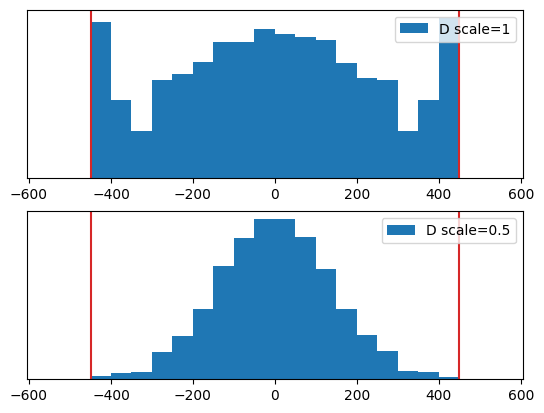

In [5]:
fig, axs = plt.subplots(2, 1)
bins = range(-550, 551, 50)
axs[0].hist(result_unscaled.flatten().cpu().type(torch.float32), density=True, bins=bins, label="D scale=1")
axs[1].hist(result_scaled.flatten().cpu().type(torch.float32), density=True, bins=bins, label="D scale=0.5")
for ax in axs:
    ax.set_yticks([])
    ax.axvline(448, color="tab:red")
    ax.axvline(-448, color="tab:red")
    ax.legend()

Notice how values are clamped to ±448 when the scale is set to 1.

### Mixing different data types for A, B, C and D

Unlike higher precision operations, for FP8 operations the types of all operands don't have to be equal. Specifically:
- A and B can both be `float8_e4m3fn`, or one of them can be `float8_e5m2`.
- C can be `float16`, `bfloat16` or `float32` (but not `float8`).
- If C is a 16-bit float, D can have the type of A, B or C.

For more details on the supported types, please refer to the [cublasLtMatmul documentation in cuBLASLt docs](https://docs.nvidia.com/cuda/cublas/#cublasltmatmul).

In nvmath-python, the default result type for D is the type of C:

In [6]:
a = torch.rand(m, k).type(torch.float8_e5m2)
b = torch.rand(n, k).type(torch.float8_e4m3fn).T
c = torch.rand(m, n).type(torch.bfloat16)
d = nvmath.linalg.advanced.matmul(a, b, c=c, beta=1, quantization_scales={"a": 1, "b": 1})
print(f"{a.dtype=} {b.dtype=} {c.dtype=} => {d.dtype=}")

a.dtype=torch.float8_e5m2 b.dtype=torch.float8_e4m3fn c.dtype=torch.bfloat16 => d.dtype=torch.bfloat16


If C is not specified, the default type for D is the type of A:

In [7]:
a = torch.rand(m, k).type(torch.float8_e5m2)
b = torch.rand(n, k).type(torch.float8_e4m3fn).T
d = nvmath.linalg.advanced.matmul(a, b, quantization_scales={"a": 1, "b": 1, "d": 1})
print(f"{a.dtype=} {b.dtype=} => {d.dtype=}")

a.dtype=torch.float8_e5m2 b.dtype=torch.float8_e4m3fn => d.dtype=torch.float8_e5m2


However, you can also request a specific type for D by setting the `result_type` option:

In [8]:
a = torch.rand(m, k).type(torch.float8_e5m2)
b = torch.rand(n, k).type(torch.float8_e4m3fn).T
options = {
    "result_type": nvmath.CudaDataType.CUDA_R_16BF  # bfloat16
}
d = nvmath.linalg.advanced.matmul(a, b, quantization_scales={"a": 1, "b": 1}, options=options)
print(f"{a.dtype=} {b.dtype=} {options=} => {d.dtype=}")

a.dtype=torch.float8_e5m2 b.dtype=torch.float8_e4m3fn options={'result_type': <CudaDataType.CUDA_R_16BF: 14>} => d.dtype=torch.bfloat16


Note that we provide a D scale only when D is FP8.

### Scale modification in stateful Matmul

Until now, we were using stateless `matmul` function to perform the multiplication. However, for repeated computations, stateful `Matmul` class should be used. For more details on the stateful and stateless APIs, visit the [nvmath-python documentation](https://docs.nvidia.com/cuda/nvmath-python/latest/overview.html#stateless-and-stateful-apis)
.
When performing multiple multiplications with a stateful `Matmul` object, you'll likely need to change the scales along with the operands. You can do this by specifying new scales as the `quantization_scales` argument of `reset_operands`:

In [9]:
a = torch.rand(m, k, device="cuda").type(torch.float8_e5m2)
b = torch.rand(n, k, device="cuda").type(torch.float8_e4m3fn).T
with nvmath.linalg.advanced.Matmul(a, b, quantization_scales={"a": 2, "b": 2, "d": 1}) as mm:
    mm.plan()
    result1 = mm.execute()
    print(f"Mean value of result with A scale set to 2: {result1.type(torch.float32).mean().item()}")
    new_a = torch.rand(m, k, device="cuda").type(torch.float8_e5m2)
    mm.reset_operands(a=new_a, quantization_scales={"a": 0.0001})  # Not that not all scales need to be reset
    result2 = mm.execute()
    print(f"Mean value of result with A scale set to 0.0001: {result2.type(torch.float32).mean().item()}")

Mean value of result with A scale set to 2: 126.25104522705078
Mean value of result with A scale set to 0.0001: 0.006436571013182402


Alternatively, you can provide the quantization scales as single-element GPU tensors (instead of Python scalars). This allows you to change them in-place:

In [10]:
a = torch.rand(m, k, device="cuda").type(torch.float8_e5m2)
b = torch.rand(n, k, device="cuda").type(torch.float8_e4m3fn).T
a_scale = torch.full((1,), 2.0, device="cuda", dtype=torch.float32)  # We'll change it in-place
with nvmath.linalg.advanced.Matmul(a, b, quantization_scales={"a": a_scale, "b": 2, "d": 1}) as mm:
    mm.plan()
    result1 = mm.execute()
    print(f"Mean value of result with A scale set to 2: {result1.type(torch.float32).mean().item()}")
    a_scale[:] = 0.0001  # Note: no reset_operands
    result2 = mm.execute()
    print(f"Mean value of result with A scale set to 0.0001: {result2.type(torch.float32).mean().item()}")

Mean value of result with A scale set to 2: 127.38880920410156
Mean value of result with A scale set to 0.0001: 0.006453291978687048


### Delayed scaling with amax

In real-world applications, choosing the scales might be non-trivial. However, in some cases, such as during the training of deep learning models, the distribution of inputs in subsequent iterations tends to be similar, which allows estimating the scales needed based on the results from previous iterations.

To facilitate choosing scales automatically, nvmath-python can output the maximum absolute value in the result, abbreviated as *amax*. To request the amax, set the `result_amax` option to `True`. When amax is requested, nvmath-python will return a tuple containing the actual result and an auxiliary output dictionary containing the amax as a single-element tensor (possibly along with other outputs).

In [11]:
a = torch.rand(m, k, device="cuda").type(torch.float8_e4m3fn)
b = torch.rand(n, k, device="cuda").type(torch.float8_e4m3fn).T
options = {"result_amax": True}
ret = nvmath.linalg.advanced.matmul(a, b, quantization_scales={"a": 1, "b": 1, "d": 1}, options=options)
print(f"{type(ret)=}")
result, aux = ret
print(f"{aux=}")

type(ret)=<class 'tuple'>
aux={'result_amax': tensor([42.3923], device='cuda:0')}


Let's now implement a simple delayed scaling approach. With delayed scaling, the amax values from previous iterations are used to compute the correct D scales for subsequent iterations. In each iteration, we will multiply two tensors with values sampled from $\mathcal{N}(0, 1)$, with each tensor scaled by a random factor sampled uniformly from $(0, 10)$.

We'll start with all scales set to 1. In each iteration, we will adjust the scale for D to:
$$
\text{scale}_D = \frac{\max(\mathtt{float8\_e4m3fn})}{\text{amax}} = \frac{448}{\text{amax}}
$$

In [ ]:
m, n, k = 1024, 1024, 2048
a = torch.zeros(m, k, device="cuda").type(torch.float8_e4m3fn)
b = torch.zeros(n, k, device="cuda").type(torch.float8_e4m3fn).T


def regenerate_inputs():
    global a, b
    a[:] = 3 * torch.randn(a.shape, device="cuda")
    b[:] = 3 * torch.randn(b.shape, device="cuda")


scales = {
    "a": 1,
    "b": 1,
    "d": torch.ones((1,), device="cuda", dtype=torch.float32),
}  # D scale is a GPU tensor to allow for in-place change
options = {"result_amax": True}
num_iters = 10
with nvmath.linalg.advanced.Matmul(a, b, quantization_scales=scales, options=options) as mm:
    mm.plan()
    for iteration in range(1, num_iters + 1):
        regenerate_inputs()
        d, aux = mm.execute()
        amax = aux["result_amax"]
        overflow_frac = (d.cpu().abs() == 448).sum() / d.nelement()
        scales["d"][:] = 448 / amax
        print(
            f"Iteration {iteration}: amax={amax}, {overflow_frac * 100:.02f}% "
            f"values are 448. Setting D scale to {scales['d'].item()}"
        )

Iteration 1: amax=tensor([2117.1724], device='cuda:0'), 28.85% values are 448. Setting D scale to 0.21160298585891724
Iteration 2: amax=tensor([1987.5466], device='cuda:0'), 0.00% values are 448. Setting D scale to 0.2254035323858261
Iteration 3: amax=tensor([2071.7327], device='cuda:0'), 0.00% values are 448. Setting D scale to 0.21624411642551422
Iteration 4: amax=tensor([2219.4202], device='cuda:0'), 0.00% values are 448. Setting D scale to 0.20185452699661255
Iteration 5: amax=tensor([1961.7855], device='cuda:0'), 0.00% values are 448. Setting D scale to 0.22836339473724365
Iteration 6: amax=tensor([2017.6495], device='cuda:0'), 0.00% values are 448. Setting D scale to 0.2220405638217926
Iteration 7: amax=tensor([2089.1074], device='cuda:0'), 0.00% values are 448. Setting D scale to 0.21444565057754517
Iteration 8: amax=tensor([2168.7864], device='cuda:0'), 0.00% values are 448. Setting D scale to 0.20656713843345642
Iteration 9: amax=tensor([2081.2173], device='cuda:0'), 0.00% val

Depending on the use case, it might be beneficial to compute the new scale based not on a single amax value, but on the history of amax values.

## MXFP8 (microscaling FP8) operations with nvmath-python

<div class="alert alert-box alert-info">
MXFP8 matrix multiplication in nvmath-python requires <b>CUDA Toolkit 12.8 or newer</b> and a device with <b>compute capability 10.0 or higher</b>. Devices with compute capability 10.0 or higher include devices based on Blackwell architecture, such as B200. Please refer to the table at <a href="https://developer.nvidia.com/cuda-gpus">https://developer.nvidia.com/cuda-gpus</a> to check the compute capability of your device. Note that you also need PyTorch version built with CUDA 12.8.
</div>

### The limits of tensor-wide scaling

Sometimes, even with scaling, getting results clamped is unavoidable. The D scale factor needs to be small enough to squeeze all (or almost all) values into the dynamic range of the FP8 type used. However, if it's too small, numbers very close to 0 turn into 0 when scaled down. To illustrate this, let's consider the following (artificial) example.

Let A and B be matrices sampled from $\mathcal{N}(0, 1)$. However, to expand the range of values, let's scale each row by a random power of 2, sampled from $2^{\;\mathcal{U}(-8, 8)}$. This example is exaggerated for learning purposes, but illustrates the problems with FP8 tensor-wide scaling well.

Absolute values in the result range from 1.998816878767684e-05 to 12908.6708984375.


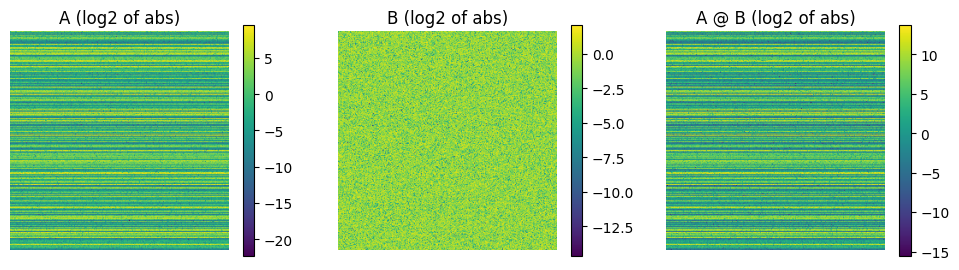

In [13]:
m, n, k = 256, 256, 256

a_fp32 = torch.randn(m, k) * (2 ** (torch.rand(m) * 16 - 8)[:, None])
b_fp32 = torch.randn(n, k).T
d_fp32 = a_fp32 @ b_fp32

fig, axs = plt.subplots(1, 3, figsize=(12, 3))
plt.colorbar(axs[0].imshow(a_fp32.abs().log2()), ax=axs[0])
axs[0].set_title("A (log2 of abs)")
axs[0].axis("off")
plt.colorbar(axs[1].imshow(b_fp32.abs().log2()), ax=axs[1])
axs[1].set_title("B (log2 of abs)")
axs[1].axis("off")
plt.colorbar(axs[2].imshow(d_fp32.abs().log2()), ax=axs[2])
# ax=axs[2])
axs[2].set_title("A @ B (log2 of abs)")
axs[2].axis("off")

print(f"Absolute values in the result range from {d_fp32.abs().min()} to {d_fp32.abs().max()}.")

With such a huge range of values, regardless of the scale we choose, either some very small values will be scaled down to 0, or some big values will be clamped to 448. Let's see on a plot how the choice of the quantization scale for D affects the number of errors of each kind.

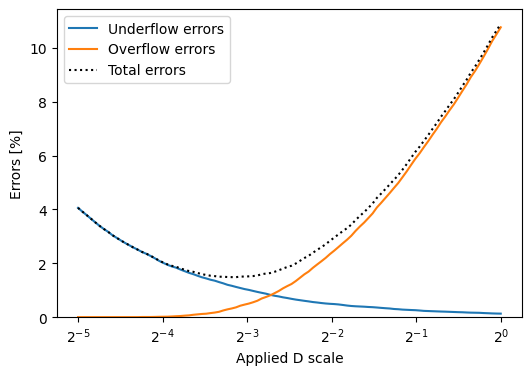

In [14]:
a = a_fp32.cuda().type(torch.float8_e4m3fn)
b = b_fp32.cuda().type(torch.float8_e4m3fn)


def count_errors(dscale):
    scales = {"a": 1, "b": 1, "d": dscale}
    d = nvmath.linalg.advanced.matmul(a, b, quantization_scales=scales)
    return (d == 0).sum().item() / d.nelement(), (d.cpu().abs() == 448).sum().item() / d.nelement()


dscales = 2 ** torch.linspace(-5, 0, 100)
errors = torch.as_tensor([count_errors(dscale) for dscale in dscales])
underflows = errors[:, 0] * 100
overflows = errors[:, 1] * 100
total_fp8_errors = underflows + overflows

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(dscales, underflows, label="Underflow errors")
ax.plot(dscales, overflows, label="Overflow errors")
ax.plot(dscales, total_fp8_errors, color="black", linestyle=":", label="Total errors")
ax.set_xscale("log", base=2)
ax.set_xlabel("Applied D scale")
ax.set_ylabel("Errors [%]")
ax.legend()
plt.ylim(ymin=0);

### Basics of MXFP8

To address this issue, MXFP8, which stands for microscaling FP8, uses *block scaling* instead of *tensor-wide scaling*: instead of applying a single scale factor to the whole matrix, separate scales are applied to blocks of 32 elements. This way, even when there are both very big and very small numbers in the matrix, it is possible keep both of them - unless, of course, both big and small values happen to be placed in the same scaling block.

MXFP8 formats were introduced in the [OCP Microscaling Formats (MX) Specification](https://www.opencompute.org/documents/ocp-microscaling-formats-mx-v1-0-spec-final-pdf). If you're interested in the details of MXFP8, we encourage you to take a look at this specification.

To enable MXFP8 in nvmath-python, set `block_scaling` option to `True`.

In MXFP8 mode, result scaling works differently. Instead of expecting the user to provide the scale for D, cuBLAS will compute appropriate scale for each block, apply the scales, and return the scaled output together with the scales used. The scales will be returned as `"d_out_scale"` in the auxiliary outputs dictionary.

As in case of FP8, you have to provide scales for A and B. Because the layout of the block scaling factor is quite complex, nvmath provides `create_mxfp8_scale` helper, which allows you to create a block scaling factors for a given tensor, filled with a constant value. The second argument of `create_mxfp8_scale` is a base 2 exponent of the scale to be used. In this case, by passing $0$ we request the scale to be $2^0=1$.

In [15]:
scales = {
    "a": nvmath.linalg.advanced.helpers.matmul.create_mxfp8_scale(a, 0),
    "b": nvmath.linalg.advanced.helpers.matmul.create_mxfp8_scale(b, 0),
}

Let's try that:

In [16]:
options = {"block_scaling": True}
result, aux = nvmath.linalg.advanced.matmul(a, b, options=options, quantization_scales=scales)  # Note: a tuple is returned
result, aux

(tensor([[-384.,  160.,   24.,  ...,  416.,  208.,  224.],
         [-120., -120., -104.,  ...,  -22.,  144.,  160.],
         [-192., -288., -120.,  ...,  224.,   96.,   15.],
         ...,
         [-416.,  416.,  384.,  ...,   18.,   32.,  -72.],
         [ 112.,  320.,  -60.,  ...,  112.,   13.,   64.],
         [ 192.,  128., -192.,  ...,  160.,  176.,  -56.]], device='cuda:0',
        dtype=torch.float8_e4m3fn),
 {'d_out_scale': tensor([128, 128, 129,  ..., 117, 117, 117], device='cuda:0',
         dtype=torch.uint8)})

We will discuss the meaning of the block scales tensor later. For now, let's just use the `apply_mxfp8_scales` to apply the returned scales to the returned D:

In [17]:
nvmath.linalg.advanced.helpers.matmul.apply_mxfp8_scale(result, aux["d_out_scale"])

tensor([[-7.6800e+02,  3.2000e+02,  4.8000e+01,  ...,  8.3200e+02,
          4.1600e+02,  4.4800e+02],
        [-3.7500e+00, -3.7500e+00, -3.2500e+00,  ..., -6.8750e-01,
          4.5000e+00,  5.0000e+00],
        [-1.8750e-01, -2.8125e-01, -1.1719e-01,  ...,  4.3750e-01,
          1.8750e-01,  2.9297e-02],
        ...,
        [-1.3000e+01,  1.3000e+01,  1.2000e+01,  ...,  1.1250e+00,
          2.0000e+00, -4.5000e+00],
        [ 2.1875e-01,  6.2500e-01, -1.1719e-01,  ...,  4.3750e-01,
          5.0781e-02,  2.5000e-01],
        [ 1.8750e-01,  1.2500e-01, -1.8750e-01,  ...,  1.5625e-01,
          1.7188e-01, -5.4688e-02]], device='cuda:0')

Let's see how many underflow/overflow errors happened in the MXFP8 computation:

In [18]:
mxfp8_underflows = 100 * (result == 0).sum() / result.nelement()
mxfp8_overflows = 100 * (result.cpu().abs() == 448).sum() / result.nelement()
mxfp8_errors = mxfp8_underflows + mxfp8_overflows

Let's see how it compares to FP8:

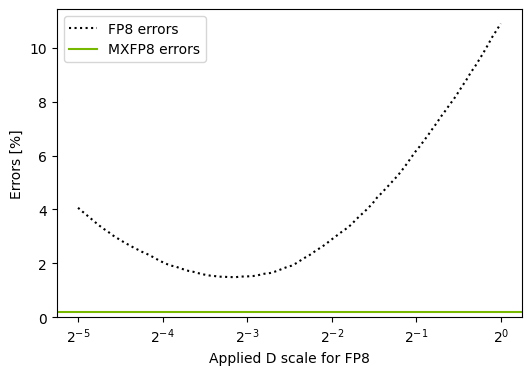

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(dscales, total_fp8_errors, label="FP8 errors", color="black", linestyle=":")
ax.axhline(mxfp8_errors.item(), label="MXFP8 errors", color="#76b900")
ax.set_xscale("log", base=2)
ax.set_xlabel("Applied D scale for FP8")
ax.set_ylabel("Errors [%]")
plt.ylim(ymin=0)
ax.legend();

In this particular case, MXFP8 performed so well, because by scaling each row by a single factor we ensured that the numbers in each MXFP8 block are of similar magnitude. If we scaled each element individually by a random power of 2, the gains from MXFP8 would be much less visible. However, in the Deep Learning workloads, MXFP8 has been demonstrated to improve the accuracy.

### MXFP8 block scales value encoding

#### Value encoding
As you may have noticed, the scales used in MXFP8 are small integers:

In [20]:
aux["d_out_scale"]

tensor([128, 128, 129,  ..., 117, 117, 117], device='cuda:0',
       dtype=torch.uint8)

Each scale is encoded in the UE8M0 format, which means an unsigned 8-bit exponent, without any exp}licit significand bits. We interpret the value $x$ as:
$
2^{x - 127}
$. For example, value `132` means that scale used was $2^{132-127}=2^5=32$.

### [Advanced] MXFP8 block scales layout

The layout of the scales is relatively complex. In typical use cases, you shouldn't have to care about it. However, in advanced use cases you may need to tweak particular scaling factors. This section is optional and for advanced users. In normal use-cases, the details of MXPF8 layout should be opaque to the user and are subject to change in future releases of nvmath-python.

We provide `get_mxfp8_scale_offset`, which given a tuple of indices in the matrix, returns the index in the scales vector containing the scale for this item. To illustrate its usage, let's create two simple matrices, and prepare unit scales for both:

In [21]:
a = torch.ones(128, 128).type(torch.float8_e4m3fn)
b = torch.eye(128).type(torch.float8_e4m3fn).T  # identity matrix
scales = {
    "a": nvmath.linalg.advanced.helpers.matmul.create_mxfp8_scale(a, 0),
    "b": nvmath.linalg.advanced.helpers.matmul.create_mxfp8_scale(b, 0),
}
result, aux = nvmath.linalg.advanced.matmul(a, b, quantization_scales=scales, options={"block_scaling": True})
actual_result = nvmath.linalg.advanced.helpers.matmul.apply_mxfp8_scale(result, aux["d_out_scale"])
actual_result

tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]])

Now, let's use `get_mxfp8_scale_offset` to get the scale for element at $(40, 70)$ in `a` and set the scale to 16x bigger value. Let's repeat the matmul and display the results. Note how changing one scale affected the whole block of 32 elements.

Offset is 134


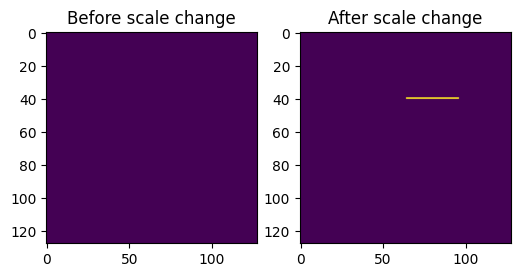

In [22]:
offset = nvmath.linalg.advanced.helpers.matmul.get_mxfp8_scale_offset(a, (40, 70))
print("Offset is", offset)
scales["a"][offset] += 4  # Increasing the exponent by 4 means scaling 16x.

result2, aux = nvmath.linalg.advanced.matmul(a, b, quantization_scales=scales, options={"block_scaling": True})
actual_result2 = nvmath.linalg.advanced.helpers.matmul.apply_mxfp8_scale(result, aux["d_out_scale"])

fig, axs = plt.subplots(1, 2, figsize=(6, 4))
axs[0].imshow(actual_result)
axs[1].imshow(actual_result2)
axs[0].set_title("Before scale change")
axs[1].set_title("After scale change");

To visualize the layout of MXFP8 scales, let's use `get_mxfp8_scale_offset` again, but this time computing the offset for each element. Note how the blocks for A (row-major layout) are laid out horizontally, while blocks of B (column-major layout) are laid out vertically. This is because the MXFP8 scales are always applied to blocks of consecutive elements in the memory.

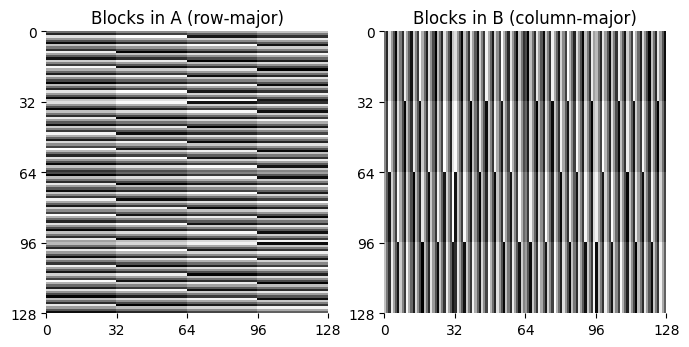

In [23]:
all_indices = torch.meshgrid(torch.arange(128), torch.arange(128), indexing="ij")
offsets_a = nvmath.linalg.advanced.helpers.matmul.get_mxfp8_scale_offset(a, all_indices)
offsets_b = nvmath.linalg.advanced.helpers.matmul.get_mxfp8_scale_offset(b, all_indices)
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow((offsets_a + 4) * 10 % 93, cmap="gray", interpolation="none")
axs[1].imshow((offsets_b + 4) * 10 % 93, cmap="gray", interpolation="none")
axs[0].set_title("Blocks in A (row-major)")
axs[1].set_title("Blocks in B (column-major)")

for ax in axs:
    ticks = range(0, 128 + 1, 32)
    ax.set_xticks([t - 0.5 for t in ticks], ticks)
    ax.set_yticks([t - 0.5 for t in ticks], ticks)
    plt.setp(ax.spines.values(), lw=0)

For more details about the MXFP8 scales layout, please visit the cuBLASLt documentation.

## Learning more
- For more examples of FP8 and MXFP8 usage, see the [examples on our GitHub](https://github.com/NVIDIA/nvmath-python/tree/main/examples/linalg/advanced/matmul).
- For more details on narrow-precision types, visit [cuBLASLt documentation](https://docs.nvidia.com/cuda/cublas/#narrow-precision-data-types-usage).